# Yelp Sentimental Analysis Using NLP

This notebook will demonstrate how we can acheive sentimental analysis with heavy dataset provided by yelp dataset challenges. The file provides us with over 4 million reviews from different businesses all over the world. This notewook will be focusing on restruant reviews. We want to be able to find correlations between resturants and provide positive and negitive sentiment on different types of foods provided by resturants. The goal is to be able to understand what the reviews are telling us in a deeper level and provide recommendations depending on user input. Not only will we provide recommendation for restruants, but we will also provide recommendations for similiar dishes.

Written by: Nathan Nguyen

In [421]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import nltk
from collections import Counter
import seaborn as sns
import datetime
import calendar
import re
import string
from wordcloud import WordCloud
import sklearn
from PIL import Image

matplotlib.rcParams['figure.figsize'] = [15, 7]
pd.options.mode.chained_assignment = None  # default='warn'
%matplotlib inline

# Loading our dataset
The data set is provided by yelp as json files. We will use pandas read_json function to read our json files into dataframes. After we've built our dataframes, we will then examine the data frame and find a business that we would like to examine and apply NLP on.

In [274]:
# Load business data

# Mac Directory
business_df = pd.read_json("../../DataScience/yelp_dataset/business.json", lines=True)

In [275]:
with open('../../DataScience/yelp_dataset/review.json') as json_file:      
    data = json_file.readlines()
    data = list(map(json.loads, data)) 

review_df = pd.DataFrame(data)

# Make copies of our dataframes
We do this so we won't accidentaly broadcast any thing and whip our dataframes

In [276]:
# Make copy of the df, so we don't overwrite the orignal data
copy_business = pd.DataFrame.copy(business_df)

In [277]:
copy_review = pd.DataFrame.copy(review_df)

# What is our target business?
We will begin analysis our dataset by using panda's built in fuctions. This will allow us to get a high level view of our data and what it consist of. This will help us determine what types of methods we will use to select the right business to use.

In [278]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4736897 entries, 0 to 4736896
Data columns (total 9 columns):
business_id    object
cool           int64
date           object
funny          int64
review_id      object
stars          int64
text           object
useful         int64
user_id        object
dtypes: int64(4), object(5)
memory usage: 325.3+ MB


In [279]:
copy_review.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,uYHaNptLzDLoV_JZ_MuzUA,0,2016-07-12,0,VfBHSwC5Vz_pbFluy07i9Q,5,My girlfriend and I stayed here for 3 nights a...,0,cjpdDjZyprfyDG3RlkVG3w
1,uYHaNptLzDLoV_JZ_MuzUA,0,2016-10-02,0,3zRpneRKDsOPq92tq7ybAA,3,If you need an inexpensive place to stay for a...,0,bjTcT8Ty4cJZhEOEo01FGA
2,uYHaNptLzDLoV_JZ_MuzUA,0,2015-09-17,0,ne5WhI1jUFOcRn-b-gAzHA,3,Mittlerweile gibt es in Edinburgh zwei Ableger...,0,AXgRULmWcME7J6Ix3I--ww
3,uYHaNptLzDLoV_JZ_MuzUA,0,2016-08-21,0,llmdwOgDReucVoWEry61Lw,4,Location is everything and this hotel has it! ...,0,oU2SSOmsp_A8JYI7Z2JJ5w
4,uYHaNptLzDLoV_JZ_MuzUA,0,2013-11-20,0,DuffS87NaSMDmIfluvT83g,5,gute lage im stadtzentrum. shoppingmeile und s...,0,0xtbPEna2Kei11vsU-U2Mw


In [280]:
copy_business.head()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state
0,691 Richmond Rd,"{'RestaurantsPriceRange2': 2, 'BusinessParking...",YDf95gJZaq05wvo7hTQbbQ,"[Shopping, Shopping Centers]",Richmond Heights,"{'Monday': '10:00-21:00', 'Tuesday': '10:00-21...",1,41.541716,-81.493116,Richmond Town Square,,44143,17,2.0,OH
1,2824 Milton Rd,"{'GoodForMeal': {'dessert': False, 'latenight'...",mLwM-h2YhXl2NCgdS84_Bw,"[Food, Soul Food, Convenience Stores, Restaura...",Charlotte,"{'Monday': '10:00-22:00', 'Tuesday': '10:00-22...",0,35.236870,-80.741976,South Florida Style Chicken & Ribs,Eastland,28215,4,4.5,NC
2,337 Danforth Avenue,"{'BusinessParking': {'garage': False, 'street'...",v2WhjAB3PIBA8J8VxG3wEg,"[Food, Coffee & Tea]",Toronto,"{'Monday': '10:00-19:00', 'Tuesday': '10:00-19...",0,43.677126,-79.353285,The Tea Emporium,Riverdale,M4K 1N7,7,4.5,ON
3,"7702 E Doubletree Ranch Rd, Ste 300",{},CVtCbSB1zUcUWg-9TNGTuQ,"[Professional Services, Matchmakers]",Scottsdale,"{'Friday': '9:00-17:00', 'Tuesday': '9:00-17:0...",1,33.565082,-111.916400,TRUmatch,,85258,3,3.0,AZ
4,4719 N 20Th St,"{'RestaurantsTableService': False, 'GoodForMea...",duHFBe87uNSXImQmvBh87Q,"[Sandwiches, Restaurants]",Phoenix,{},0,33.505928,-112.038847,Blimpie,,85016,10,4.5,AZ


In [281]:
# Sort business review
highest_review = business_df.review_count.sort_values(ascending=False)
highest_review.head()

103325    6979
125404    6417
45588     5632
114018    5429
100916    4789
Name: review_count, dtype: int64

In [282]:
target_location = copy_business.iloc[[103325]]

In [283]:
target_location.head()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state
103325,3655 Las Vegas Blvd S,"{'Alcohol': 'full_bar', 'HasTV': False, 'Noise...",4JNXUYY8wbaaDmk3BPzlWw,"[French, Steakhouses, Breakfast & Brunch, Rest...",Las Vegas,"{'Monday': '7:00-23:00', 'Tuesday': '7:00-23:0...",1,36.112827,-115.172581,Mon Ami Gabi,The Strip,89109,6979,4.0,NV


In [284]:
target_review = copy_review[copy_review['business_id'] == target_location.business_id.values[0]]
target_review = target_review.reset_index(drop=True)

In [285]:
target_review.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,4JNXUYY8wbaaDmk3BPzlWw,0,2011-02-22,0,WE9eUYf5EV8AxJjl8QZRtA,5,"Very chic. Although, the menu items doesnt SCR...",0,K6FpHYwcJYznoXXu8ySZHw
1,4JNXUYY8wbaaDmk3BPzlWw,0,2015-04-15,0,7Fl41hKa0wjO3TlvHKD3lw,4,Cute french bistro with great service. I came ...,1,3SGQKsO1J-jcRIp3WNxCeA
2,4JNXUYY8wbaaDmk3BPzlWw,0,2013-11-11,0,Jm4iOfsltS3T59puoV6r8Q,5,"The food is very good, the prices fair and the...",0,LPT8XlpXlHGAp0Ri4Hu4Rw
3,4JNXUYY8wbaaDmk3BPzlWw,3,2015-12-28,2,m6lwvXPCdpKHVp05Bjkhlw,5,One of my favorite go-to brunch spots on the L...,8,3NnPbhmv_vEfPTBp2pnn9Q
4,4JNXUYY8wbaaDmk3BPzlWw,0,2015-09-16,0,nkb40j7kBe2qAci1xpyd3g,5,Simply amazing steak and frites. Got the blue ...,0,xl4rsQqpibUNhR8Jqxp4OQ


# Conclusion
After reviewing our data, sorting, and figuring out which business had the most review, we came to the conclusion of what business we will move forward with. Our selected business is name Mon Ami Gabi and is located in the middle of Las Vegas stripe. This resturant gives our 6979 reviews for us to apply NLP.

# What is the frequency of stars given for this resutrant?
We want to run thorugh the dataframe star series and convert this into something that is more appealing to the human eye. By introducing a bar chart, we can clearly see the distrubition and the frequecy of stars given for this resturant.

In [286]:
def stars_freq(target):
    # Plot histogram of review stars
    star_count = pd.DataFrame({'stars':target.stars})

    # Count number of frequency
    labels, values = zip(*Counter(star_count.stars).items())

    # Create index for bar chart
    index = np.arange(len(labels))
    
    # Plot the freq hisotgram
    _ = plt.bar(labels, values, edgecolor = "black", color='teal')
    _ = plt.xlabel("Stars")
    _ = plt.ylabel("Frequecy")
    _ = plt.title('Frequency of Stars Given')
    plt.show()
    
    # Print frequency information
    print(labels)
    print(values)
    
    # Create a percentage list from the review
    star_percentage = [(value / len(target_review.stars)) * 100 for value in values]
    star_percentage = zip(labels, star_percentage)
    star_percentage = set(star_percentage)

    for x in star_percentage:
        print(x)

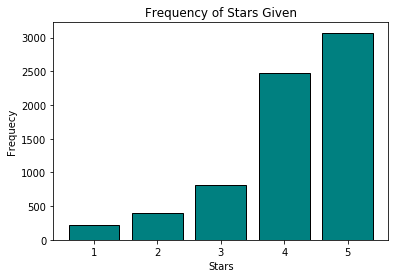

(5, 4, 3, 2, 1)
(3073, 2471, 809, 400, 225)
(1, 3.224419604471195)
(5, 44.0384064201777)
(3, 11.593579822298652)
(4, 35.411292633992545)
(2, 5.732301519059903)


In [287]:
stars_freq(target_review)

This resturant shows has a very high satisfaction rate when it comes to stars given for the resturant. What the bar chart tells us is that the resutanrt received the number of ratings listed below:

    5 Star: 3073 (44.03%)
    4 Star: 2471 (35.41%)
    3 Star: 809  (11.59%)
    2 Star: 400  (5.73%)
    1 Star: 225  (3.22%)
    
This resturant clearly shows that it is providing their customers with the best service possible. There is clearly a possivite relationship between the serivce provided and the stars given by the users.

In [500]:
def review_by_date(target, star):
    
    # Create a temp df and cast date series to datetime64
    temp_df = target
    temp_df.date = pd.to_datetime(target.date)
    
    target_date = []
    
    # Iterate through df series to get name of the weekday and append to a list
    for x in temp_df.date:
        target_date.append(x.weekday_name)
        
    temp_df['day'] = target_date
    
    test = temp_df[temp_df.stars == star]
    
    # Count number of frequency
    labels, values = zip(*Counter(test.day).items())
    
    # Create index for bar chart
    index = np.arange(len(labels))
    
    plt.bar(index, values, edgecolor='black')
    plt.xticks(index, labels)
    plt.xlabel('Days Of The Week')
    plt.ylabel("Review Count")  
    plt.show()

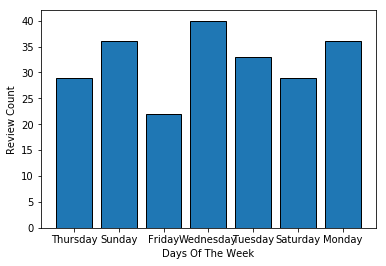

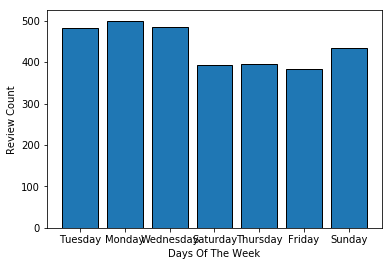

In [289]:
review_by_date(target_review, 1)
review_by_date(target_review, 5)

This bar graph lets us see which day of the week the resturant experience the worst & best service. Clearly we can see that 

# Converting all reviews into a review vector

In [292]:
# Create empty string
raw_doc = ""

# Iterate through the reviews and store it into a raw source
for count, x in enumerate(target_review.text):
    raw_doc += x

# Create new file to write raw string to
review_file = open('txt files/Review_Doc.txt', 'w')
review_file.write(raw_doc)
review_file.close()

In [498]:
# Import vector file from fasttext
try:
    review_vec_file = open('../../DataScience/yelp_dataset/Reivew_Vec_Out.vec')
    
except IOError:
    print("File doesn't exsist")
    
nWords = 7888

# Create a matrix filled with 0's (7888 x 100)
embVectors = np.mat(np.zeros((nWords, 100)))
embIndices = {}

# Read first line and create a counter variable
line = review_vec_file.readline()
counter = 0

for line_pos in range(0, nWords):
    
    # Read the next line in vector file and split it up and lowercase the word
    line = review_vec_file.readline()
    line_split = line.split()
    word = line_split[0].lower()
    
    # Iterate through the vectors of the word
    if word not in embIndices:
        try:
            # Get vector array from index 1 to 100
            vec = np.array([float(x) for x in line_split[1:]])
            
            # Normalize 
            vec = vec / np.sqrt(np.dot(vec, vec))
            
            # Create a word reference list
            embIndices[word] = counter
            embVectors[counter, : ] = vec
            
            counter += 1
            
        except:
            continue
            
review_vec_file.close()

embVectors = embVectors[:len(embIndices),:]
# Reverse the dictionary.
rvrs = {embIndices[x]:x for x in embIndices} 

# Splitting reviews into (+) and (-) sentiments

In order to do a sentimental analysis on our data, we much first split the data into positive and negitive reviews. Yelp data gives us star rating per review ranging from 1 to 5 stars. One being the feast recommended and five being highly recommended. We will classify the following:

(+) sentiment : 5, 4 stars <br>
(-) sentiment : 3, 2, 1 stars

We will utilize pandas boolean operations to make it simple and clean. After splitting our data, we will also proceed with preprocessing the data for future analysis. This includes removing any stop words, lowercasing all of our reviews, and lemmatizing each string. We will utilize nltk combined with regular expression to carry this out all in a function.

In [695]:
"""
    This function will remove stop words, lowercase each string, and lemmatize our rewviews.
    @params: a corpus
    @return: preprocess corpus
"""
def preprocessing(review):
    
    lemmantizer = nltk.WordNetLemmatizer()

    # Remove punctuations, split by space, and remove stop words
    review = re.sub(r'[^\w\s+]','',review).lower()
    review = review.split(' ')
    review = [lemmentizer.lemmatize(word) for word in review if word not in nltk.corpus.stopwords.words('english')]
    
    return review

In [696]:
# Split reviews into positive and negitive sentiment
pos_review = target_review[(target_review.stars == 5) | (target_review.stars == 4)]
neg_review = target_review[(target_review.stars == 3) | (target_review.stars == 2) | (target_review.stars == 1)]

Next, we will have to generate txt files for both positive and negitive reviews to generate our word clod

In [700]:
# Empty string
raw_doc_pos = ""

# Create our text files
pos_review_text = open('txt_files/pos_review_text.txt', 'w')
neg_review_text = open('txt_files/neg_review_text.txt', 'w')


### Pos Review ###
# Iterate through the text file to append to empty string (Pos Review)
for x in pos_review.text:
    raw_doc_pos += x

# Preprocess raw_doc string
raw_doc_pos = preprocessing(raw_doc_pos)
raw_doc_pos = ' '.join(raw_doc_pos)

# Write to our txt file
pos_review_text.write(raw_doc_pos)


### Neg Review ###
raw_doc_neg = ""

for x in neg_review.text:
    raw_doc_neg += x

# Preprocess raw_doc string
raw_doc_neg = preprocessing(raw_doc_neg)
raw_doc_neg = ' '.join(raw_doc_neg)    
   
neg_review_text.write(raw_doc_neg)

pos_review_text.close()
neg_review_text.close()

In [701]:
"""
    This function will generate word cloud given a text string.
    @param: corpus and title for the word cloud
"""
def generate_wordcloud(content, title, fp):

    fp = 'Img/{}.png'.format(fp)
    
    mask = np.array(Image.open(fp))
    
    
    word_cloud = WordCloud(background_color='black', 
                           mode='RGB',
                           mask=mask,
                           width=2000, 
                           height=1000).generate(content)
    
    plt.figure(figsize=(20,10))
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.title(title, fontsize=50)
    plt.imshow(word_cloud)

In [702]:
with open('txt_files/pos_review_text.txt', 'r') as pos_review_text:
    pos_content = pos_review_text.read()
    
with open('txt_files/neg_review_text.txt', 'r') as neg_review_text:
    neg_content = neg_review_text.read()

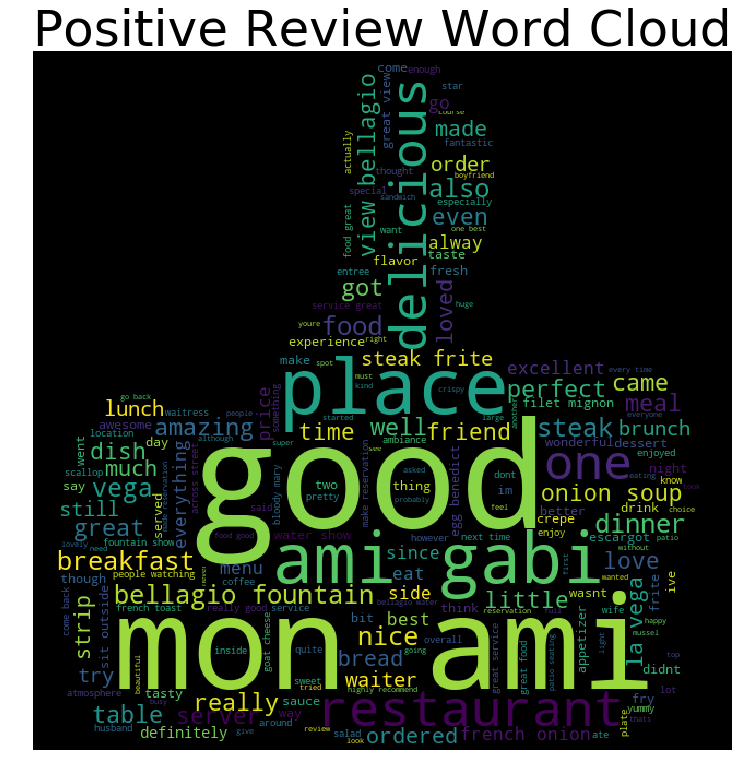

In [704]:
generate_wordcloud(pos_content, "Positive Review Word Cloud", 't_up')

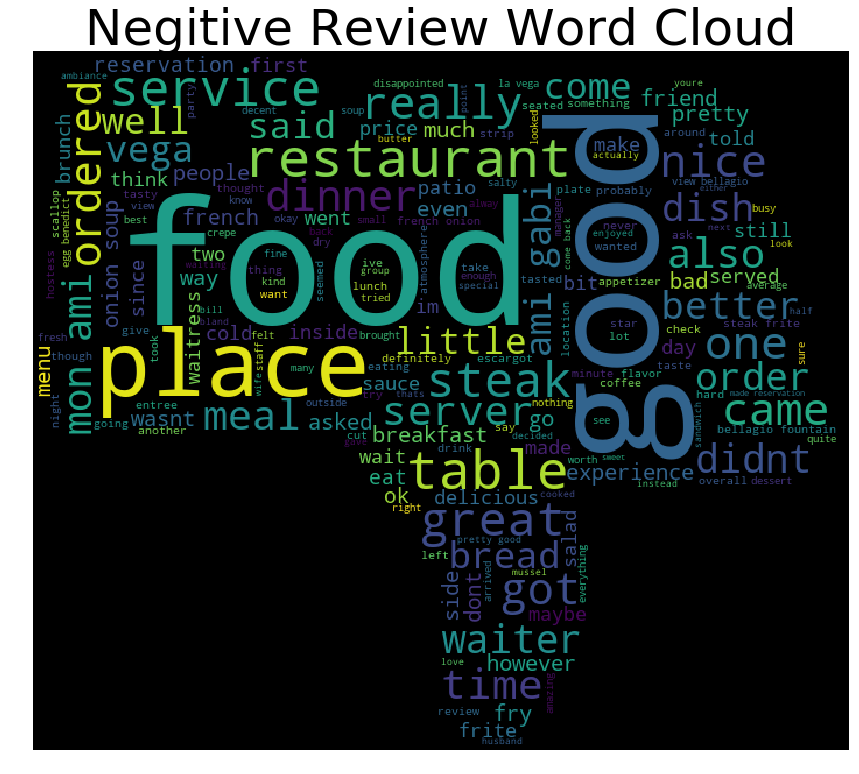

In [705]:
generate_wordcloud(neg_content, "Negitive Review Word Cloud", 't_down')

# Find out word frequency
We want to tokenize out each review and be able to find out the most common words being used by users. In order to do so, we will iterate through the dataset and call nltk tokenize. This will create a list of words, which we will then append to a list. However, this will create a list of list, which we will then flatten out with list comprehension and make all words lower case. We also want to tweak our algorithm in order to remove common words and puncuations, because nltk recongize those as words and will be irrelevant to our frequency count.

In [728]:
# Create an empty list
all_words_pos = []
all_words_neg = []

# Tokenize raw strings
word_pos = nltk.word_tokenize(raw_doc_pos)
word_neg = nltk.word_tokenize(raw_doc_neg)

all_words_pos.append(word_pos)
all_words_neg.append(word_neg)

for sublist in all_words_pos:
    all_words_pos = sublist
    
for sublist in all_words_neg:
    all_words_neg = sublist

In [731]:
all_words_pos = nltk.FreqDist(all_words_pos)
print(all_words_pos.most_common(100))

[('great', 3664), ('good', 3633), ('food', 3567), ('steak', 3106), ('place', 2695), ('service', 2597), ('vega', 2410), ('time', 2305), ('french', 2298), ('restaurant', 2083), ('patio', 2029), ('bellagio', 1886), ('view', 1786), ('delicious', 1748), ('get', 1712), ('ordered', 1690), ('one', 1673), ('like', 1626), ('really', 1579), ('fountain', 1570), ('outside', 1501), ('also', 1482), ('dinner', 1475), ('would', 1442), ('ami', 1437), ('nice', 1424), ('strip', 1420), ('table', 1409), ('best', 1406), ('breakfast', 1362), ('bread', 1349), ('mon', 1344), ('u', 1340), ('got', 1302), ('reservation', 1289), ('go', 1285), ('the', 1255), ('gabi', 1236), ('wait', 1225), ('well', 1205), ('amazing', 1201), ('meal', 1184), ('came', 1154), ('come', 1120), ('definitely', 1118), ('back', 1104), ('frites', 1069), ('perfect', 1060), ('sauce', 1049), ('cheese', 1023), ('egg', 1023), ('people', 1019), ('right', 1004), ('soup', 992), ('make', 988), ('love', 980), ('i', 950), ('onion', 947), ('wine', 942), (

In [732]:
all_words_neg = nltk.FreqDist(all_words_neg)
print(all_words_neg.most_common(100))

[('food', 1273), ('good', 1120), ('steak', 958), ('service', 762), ('place', 712), ('restaurant', 671), ('ordered', 658), ('like', 654), ('table', 636), ('u', 617), ('would', 615), ('french', 596), ('time', 582), ('great', 576), ('really', 525), ('came', 499), ('one', 490), ('get', 480), ('got', 476), ('nice', 431), ('didnt', 426), ('back', 419), ('vega', 386), ('view', 376), ('server', 376), ('bread', 375), ('go', 372), ('dinner', 367), ('patio', 365), ('also', 358), ('meal', 347), ('reservation', 346), ('pretty', 346), ('order', 339), ('come', 338), ('the', 336), ('better', 333), ('dont', 331), ('soup', 327), ('even', 322), ('wait', 318), ('well', 310), ('ami', 308), ('wasnt', 305), ('i', 304), ('frites', 300), ('star', 299), ('friend', 297), ('much', 295), ('waiter', 289), ('people', 286), ('onion', 284), ('mon', 282), ('outside', 278), ('dish', 276), ('little', 273), ('strip', 271), ('could', 268), ('bellagio', 268), ('fry', 267), ('experience', 267), ('sauce', 267), ('salad', 259)